## Variational Autoencoders

In [6]:
import pickle, gzip
import matplotlib.pyplot as plt 
import numpy as np
import sys
%matplotlib inline
np.random.seed(0)

In [7]:
sys.path.append('..\\vae')
from vae import vae

In [8]:
with gzip.open('..\\resources\\mnist.pkl.gz', 'rb') as f:
    train, test, val = pickle.load(f, encoding='latin1')
    mnist_train = train[0]
    mnist_test = test[0]

The difference between a Variational Autoencoder and other autoencoder networks is that it explicitly learns a latent variable representation of the data. 
Our modeling assumption is that the data (in this case, handwritten digits) comes from a latent variable $z$.

$$z \sim N(0, I)$$

We want to find the posterior $P(z \mid x)$, but the computation is intractable. Other methods such as MCMC are computational expensive. The method we will use is variational inference. We will learn an approximation of the posterior $Q(z \mid x)$. We achieve by adding a regularization term that minimizes the KL divergence between the encoder output $x \sim N(\mu, \sigma^2 I)$ and the latent variable representation. 

$$D_{kl}(q || p) = -\frac{1}{2} \sum (1 + log(\sigma^2) - \mu^2 - \sigma^2) $$

The result is a generative models that can produce new images that are similar to ones it has seen.  

In [25]:
import numpy as np

class vae(object):

    def __init__(self, input_dim, output_dim, params, latent_dim = 2):
        '''intializes weights matrix and parameters'''

        # initialize size of VAE
        self.latent_dim = latent_dim
        self.encoder_layer_sizes = input_dim + [2]
        self.decoder_layer_sizes = [latent_dim] + output_dim[::-1] 
        self.total_layer_sizes   = input_dim + [2, latent_dim] + output_dim[::-1]
       
        self.number_encoder_layers = len(self.encoder_layer_sizes) - 1
        self.number_decoder_layers = len(self.decoder_layer_sizes) - 1
        self.number_total_layers   = len(self.total_layer_sizes) - 1

        # intialize weights
        np.random.seed(10086)
        self.encoder_weights = {}
        for i in range(self.number_encoder_layers):
            self.encoder_weights[i] = np.random.uniform(-0.1, 0.1, 
                                                        (self.encoder_layer_sizes[i], 
                                                         self.encoder_layer_sizes[i+1])) 
        self.decoder_weights = {}
        for i in range(self.number_decoder_layers):
            self.decoder_weights[i] = np.random.uniform(-0.1, 0.1, 
                                                        (self.decoder_layer_sizes[i],
                                                         self.decoder_layer_sizes[i+1]))
        # set params
        self.alpha = params['alpha']
        self.max_iter = params['max_iter']
        self.activation = params['activation']
        self.grad_activation = params['grad_act']
        self.reconst_loss = params['loss']
        self.reconst_grad = params['grad_loss']
        self.mode = params['mode']
        
        if self.mode is 'autoencoder':
            self.loss = self.reconst_loss
            self.grad_loss = self.reconst_grad
        else:
            self.loss = (lambda y, yhat: self.reconst_loss(y, yhat) + self.KLD_loss())
            self.grad_loss = self.reconst_grad
    
    def KLD_loss(self):
        '''Kullback–Leibler divergence loss'''
        return - 0.5 * np.sum(1 + self.sigma - self.mu**2 - np.exp(self.sigma), axis=-1)
    
    def KLD_grad(self):
        '''Kullback–Leibler divergence loss'''
        return np.array([self.mu, 0.5 -0.5 / self.sigma])
        
    def backprop(self, X, y, yhat):
        '''back-propagation algorithm'''
        # initialize 
        grad_decoder = {}
        grad_encoder = {}
    
        # backpropogate error through decoder layers
        rev_range = np.arange(self.number_decoder_layers)[::-1]
        n = rev_range[0]
        
        if n == 0:
            delta = - self.grad_loss(y, yhat) * self.grad_activation(self.decoder_input[0])
            grad_decoder[0] = self.encoder_activation[0].T @ delta / X.shape[0]
        else:
            delta = - self.grad_loss(y, yhat) * self.grad_activation(self.decoder_input[n])
            grad_decoder[n] = self.decoder_activation[n-1].T @ delta / X.shape[0]
            
            for i in rev_range[1:-1]:
                delta = delta @ self.decoder_weights[i+1].T * self.grad_activation(self.decoder_input[i])
                grad_decoder[i] = self.decoder_activation[i-1].T @ delta / X.shape[0]
            
            delta = delta @ self.decoder_weights[1].T * self.grad_activation(self.decoder_input[0])
            grad_decoder[0] = self.encoder_activation[1].T @ delta / X.shape[0]

        # backpropogate errors through encoder layers
        rev_range = np.arange(self.number_encoder_layers)[::-1]
        n = rev_range[0]
        delta_kld = self.KLD_grad().T * self.grad_activation(self.encoder_input[n])
        
        if n == 0:
            delta = delta @ self.decoder_weights[0].T * self.grad_activation(self.encoder_input[0])
            if self.mode is 'vae':
                delta = delta + delta_kld
            grad_encoder[0] = X.T @ delta / X.shape[0]

        else:
            delta = delta @ self.decoder_weights[0].T * self.grad_activation(self.encoder_input[n])
            if self.mode is 'vae':
                delta = delta + delta_kld
            grad_encoder[n] = self.encoder_activation[0].T @ delta /X.shape[0]
        
            for i in rev_range[1:-1]:
                delta = delta @ self.encoder_weights[i+1].T * self.grad_activation(self.encoder_input[i])
                grad_encoder[i] = self.encoder_activation[i-1].T @ delta /X.shape[0]
                
            delta = delta @ self.encoder_weights[1].T * self.grad_activation(self.encoder_input[0])
            grad_encoder[0] = X.T @ delta /X.shape[0]
    
        return grad_encoder, grad_decoder 
            
    def feedforward(self, train_data):
        '''feedforward update step'''
        
        # initialize storage for activations
        self.encoder_input = {}
        self.encoder_activation = {}
        self.decoder_input = {}
        self.decoder_activation = {}
        
        self.encoder_input[0]      = train_data @ self.encoder_weights[0]
        self.encoder_activation[0] = self.activation(self.encoder_input[0])
            
        # feedforward update on encoder network
        for i in range(1, self.number_encoder_layers):
            self.encoder_input[i] = self.encoder_input[i-1] @ self.encoder_weights[i]
            self.encoder_activation[i] = self.activation(self.encoder_input[i])
        
        # store output as encoded latent variable parameters
        self.mu = self.encoder_activation[self.number_encoder_layers - 1][:,1]
        self.sigma = self.encoder_activation[self.number_encoder_layers - 1][:,0]
        
        # sample latent variable using reparameterization trick
        if self.mode is 'vae':
            self.epsilon = np.random.normal(0, 1, (self.mu.size, self.latent_dim))
            self.z = self.mu[:, None] + self.sigma[:,None] * self.epsilon
        else:
            self.z = self.encoder_activation[self.number_encoder_layers - 1]
    
        # feedforward update on the decoder network
        self.decoder_input[0]      = self.z @ self.decoder_weights[0]
        self.decoder_activation[0] = self.activation(self.decoder_input[0])
        
        for i in range(1, self.number_decoder_layers):
            self.decoder_input[i] = self.decoder_input[i-1] @ self.decoder_weights[i]
            self.decoder_activation[i] = self.activation(self.decoder_input[i])

        return self.decoder_activation[self.number_decoder_layers - 1]
    
    
    def train(self, X, y):
        '''trains the VAE model'''
        for i in range(self.max_iter):
            yhat = self.feedforward(X)
            grad_encoder, grad_decoder = self.backprop(X, y, yhat)
            for i in range(self.number_decoder_layers):
                self.decoder_weights[i] -= self.alpha * grad_decoder[i]
        
            for j in range(self.number_encoder_layers):
                self.encoder_weights[j] -= self.alpha * grad_encoder[j]
                change = grad_encoder[j]
                
        return None

    def predict(self, X):
        '''predicts on a trained VAE model'''        
        return self.feedforward(X)
    
    def generate(self, z):
        '''generates new images from a trained VAE model'''        
        # feedforward on decoder
        self.gen_input = {}
        self.gen_activation = {}
        self.gen_input[0]     = z.T @ self.decoder_weights[0]
        self.gen_activation[0] = self.activation(self.gen_input[0])
        
        for i in range(1, self.number_decoder_layers):
            self.gen_input[i] = self.gen_input[i-1] @ self.decoder_weights[i]
            self.gen_activation[i] = self.activation(self.gen_input[i])

        return self.gen_activation[self.number_decoder_layers - 1]

In [26]:
params = {
    'alpha' : 0.2,
    'max_iter' : 100,
    'activation' : (lambda x: 1 / (1 + np.exp(-x))),
    'grad_act' : (lambda x: np.exp(-x) / (1 + np.exp(-x))**2),
    'loss' : (lambda y, yhat: 0.5 * np.sum((y - yhat)**2)),
    'grad_loss' : (lambda y, yhat: y - yhat),
    'mode' : 'vae'
}

example = vae([784, 200], [784, 200], params)

In [28]:
example.mu

AttributeError: 'vae' object has no attribute 'mu'

### Training

Here we pass in a set of training digits. From there the network will reconstruct a latent variable representation.

In [24]:
example.train(mnist_train, mnist_train)

KeyboardInterrupt: 

Now let's inspect the generated images compared to the originals. 

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (10, 6))

for i in range(3):
    in_digit = mnist_test[i][None,:]
    out_digit = example.predict(in_digit)
    ax[0,i].matshow(in_digit.reshape((28,28)),  cmap='gray', clim=(0,1))
    ax[1,i].matshow(out_digit.reshape((28,28)), cmap='gray', clim=(0,1))
pass

### Generating

We can now generate new images as well.

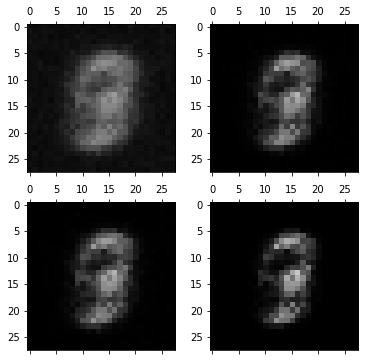

In [7]:
fig, ax = plt.subplots(2,2, figsize = (6, 6))

a = np.array([1, 3])
b = np.array([1, 3])

for i, z1 in enumerate(a):
    for j, z2 in enumerate(b):
        ax[i,j].matshow(example.generate(np.array([z1,z2])).reshape((28,28)),  cmap='gray', clim=(0,1))
pass

### References

1. [MNIST data](http://deeplearning.net/tutorial/gettingstarted.html)